# Mismatch negativity analysis

- description
- references [...]

## MMN from the LFP

### Raw data 

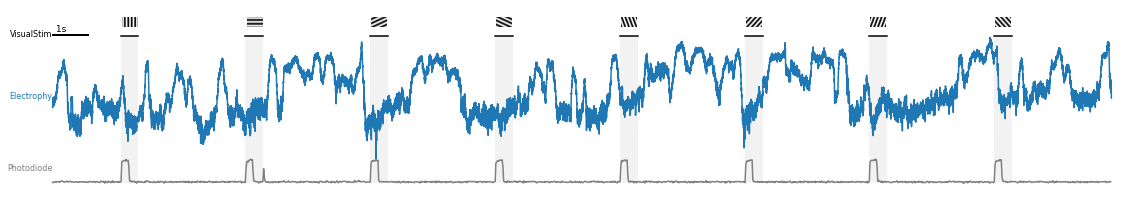

In [28]:
# general modules
import pynwb, os, sys
import numpy as np
import matplotlib.pylab as plt

# custom physion module
sys.path.append('..')
from physion.dataviz.show_data import MultimodalData

filename = '/home/yann/DATA/Electrophy/2021_05_05/2021_05_05-14-26-31.nwb'

data = MultimodalData(filename)

plot_settings = {'settings':{'Photodiode':dict(fig_fraction=.2, subsampling=10, color='grey'),
                            'Electrophy':dict(fig_fraction=1, subsampling=10, color=plt.cm.tab10(0)),
                            'VisualStim':dict(fig_fraction=0.02, color='black', size=0.2)},'Tbar':1}

tlim = [100, 130]
fig, ax = plt.subplots(1, figsize=(15,3));plt.subplots_adjust(right=1., left=0.)
_ = data.plot(tlim, ax=ax, **plot_settings)

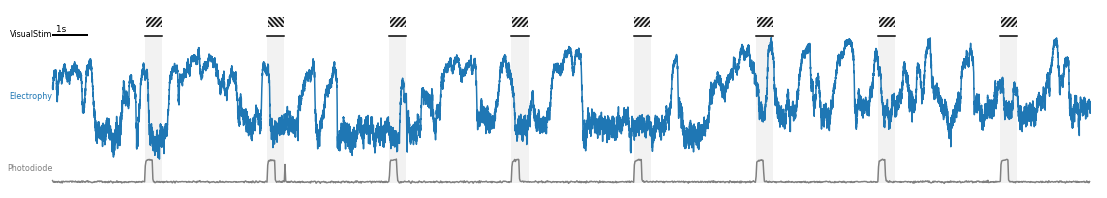

In [29]:
tlim = [700, 730]
fig, ax = plt.subplots(1, figsize=(15,3));plt.subplots_adjust(right=1., left=0.02)
_ = data.plot(tlim, ax=ax, **plot_settings)

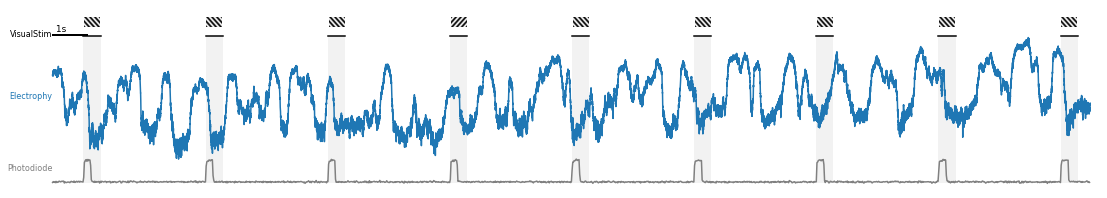

In [30]:
tlim = [1200, 1230]
fig, ax = plt.subplots(1, figsize=(15,3));plt.subplots_adjust(right=1., left=0.02)
_ = data.plot(tlim, ax=ax, **plot_settings)

### Trial averaging

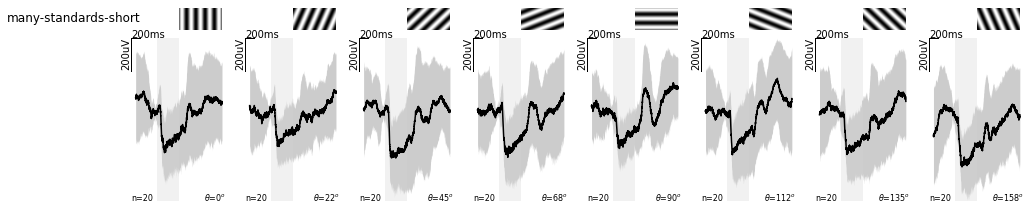

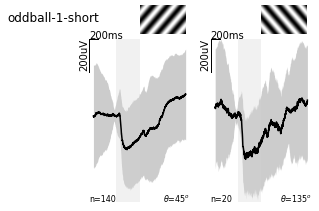

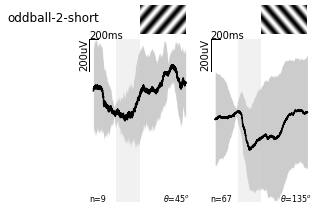

In [31]:
from physion.analysis.trial_averaging import build_episodes
from physion.dataviz.tools import add_bar_annotations

baseline_window = [-100e-3, 0] # in seconds
view_window = [-0.5, 1.5]
   
# looping over the 3 protocols of this recording session
for ip, protocol in enumerate(data.protocols):
    
    EPISODES = build_episodes(data,
                              protocol_id=ip,
                              quantity='Electrophysiological-Signal',
                              dt_sampling=1, verbose=False)
    
    # finding the angles scanned
    angles = np.unique(EPISODES['angle'])
    
    #
    baseline_cond = (EPISODES['t']>baseline_window[0]) & (EPISODES['t']<baseline_window[1])
    view_cond = (EPISODES['t']>view_window[0]) & (EPISODES['t']<view_window[1])
    ylim = [np.inf, -np.inf]
   
    fig, AX = plt.subplots(1, len(angles), figsize=(2*len(angles), 3))
    AX[0].annotate(protocol+'\n', (0.1, 1.01), ha='right', fontsize=12, xycoords='axes fraction')
    
    for ax, angle in zip(AX, angles):
        
        cond = (EPISODES['angle']==angle)
        baselines = np.mean(EPISODES['resp'][:,baseline_cond], axis=1)[cond].reshape((np.sum(cond),1))

        my = np.mean(EPISODES['resp'][cond,:]-baselines, axis=0)[view_cond]
        sy = np.std(EPISODES['resp'][cond,:]-baselines, axis=0)[view_cond]
        ax.plot(EPISODES['t'][view_cond], my, 'k-')
        ax.fill_between(EPISODES['t'][view_cond], my-sy, my+sy, color='k', alpha=.2, lw=0)
        ax.annotate('n=%i' %  (np.sum(cond)), (0,0), fontsize=8, xycoords='axes fraction')
        ax.annotate('$\\theta$=%.0f$^o$' % angle, (1,0), ha='right', fontsize=8, xycoords='axes fraction')
        
        ylim = [np.min([ylim[0], np.min(my-sy)]), np.max([ylim[1], np.max(my+sy)])]
        
        axi = ax.inset_axes([0.5, 0.99, 0.45, 0.45*9/16.])
        data.visual_stim.show_frame(np.argwhere((data.nwbfile.stimulus['angle'].data[:]==angle))[0][0],
                                    ax=axi, label=None)
        
    for ax, angle in zip(AX, angles):
        ax.set_ylim(ylim)
        ax.axis('off')
        ax.fill_between([0, EPISODES['time_duration'][np.argwhere(cond)[0][0]]],
                       np.ones(2)*ylim[0], np.ones(2)*ylim[1], color='lightgrey', alpha=0.3, lw=0)
        add_bar_annotations(ax, Xbar=0.2, Xbar_label='200ms', Ybar=0.2, Ybar_label='200uV')

### condition summary

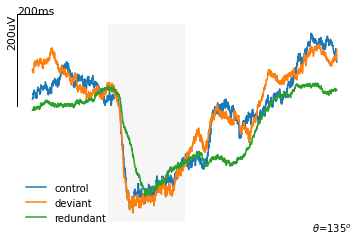

In [32]:
baseline_window = [-100e-3, 0] # in seconds
view_window = [-0.5, 1.5]

angle = 135.0


fig, ax = plt.subplots(1)

for condition, ip, protocol, color in zip(['control', 'deviant', 'redundant'],
                                  range(3),
                                  data.protocols, 
                                  [plt.cm.tab10(i) for i in range(3)]):
    
    EPISODES = build_episodes(data,
                              protocol_id=ip,
                              quantity='Electrophysiological-Signal',
                              dt_sampling=1, verbose=False)
    
 
    baseline_cond = (EPISODES['t']>baseline_window[0]) & (EPISODES['t']<baseline_window[1])
    view_cond = (EPISODES['t']>view_window[0]) & (EPISODES['t']<view_window[1])
    
    
    cond = (EPISODES['angle']==angle)
    
    baselines = np.mean(EPISODES['resp'][:,baseline_cond], axis=1)[cond].reshape((np.sum(cond),1))

    my = np.mean(EPISODES['resp'][cond,:]-baselines, axis=0)[view_cond]
    
    ax.plot(EPISODES['t'][view_cond], my, '-', color=color, label=condition)
    
ax.annotate('$\\theta$=%.0f$^o$' % angle, (1,0), ha='right', fontsize=10, xycoords='axes fraction')
ax.legend(frameon=False)

ax.fill_between([0, EPISODES['time_duration'][np.argwhere(cond)[0][0]]],
                np.ones(2)*ax.get_ylim()[0], np.ones(2)*ax.get_ylim()[1], color='lightgrey', alpha=0.2, lw=0)

add_bar_annotations(ax, Xbar=0.2, Xbar_label='200ms', Ybar=0.2, Ybar_label='200uV', fontsize=11)    
    
ax.axis('off');

## MMN from Calcium Imaging

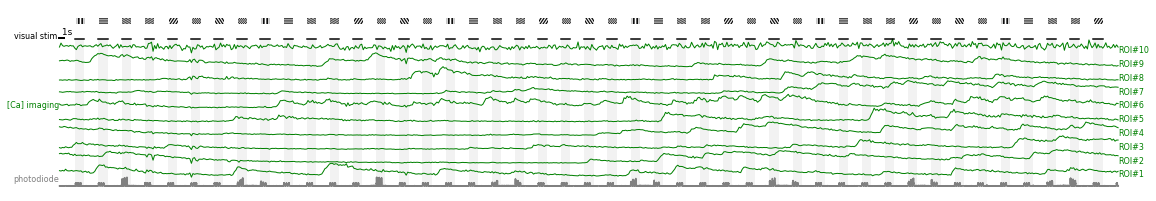

In [12]:
# general modules
import pynwb, os, sys
import numpy as np
import matplotlib.pylab as plt

# custom physion module
sys.path.append('..')
from physion.dataviz.show_data import MultimodalData

filename = '/home/yann/DATA/CaImaging/Wild_Type_GCamp6s/2021_05_18/2021_05_18-14-04-59.nwb'

data = MultimodalData(filename)

plot_settings = {'settings':{'Photodiode':dict(fig_fraction=.2, subsampling=10),
                             'CaImaging':dict(fig_fraction=3, subsampling=10, roiIndices=np.arange(10)),
                             'VisualStim':dict(fig_fraction=0.02, size=0.2)},'Tbar':1}

tlim = [100, 330]
fig, ax = plt.subplots(1, figsize=(15,3));plt.subplots_adjust(right=1., left=0.)
_ = data.plot(tlim, ax=ax, **plot_settings)

In [24]:
# find angles used for MMN
for ip, protocol in enumerate(data.protocols):
    cond_protocol = (data.nwbfile.stimulus['protocol_id'].data[:]==ip)
    print('for protocol "%s", angles' % protocol,
          np.unique(data.nwbfile.stimulus['angle'].data[cond_protocol]))

for protocol "many-standards", angles [  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
for protocol "oddball-1", angles [ 45. 135.]
for protocol "oddball-2", angles [ 45. 135.]


In [ ]:
ANGLES = [45., 135.]

In [21]:
np.unique(data.nwbfile.stimulus['angle'].data[:])

array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])

In [4]:
ls /home/yann/DAT

A/CaImaging/Wild_Type_GCamp6s/2021_05_18/2021_05_18-14-04-59.nwb

2021_05_18-14-04-59.nwb
